In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

tf.__version__

'2.1.0'

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X, y = np.concatenate([train[0], test[0]]), np.concatenate([train[1], test[1]])
X = X / 255.0
X.shape, y.shape

((70000, 28, 28), (70000,))

8

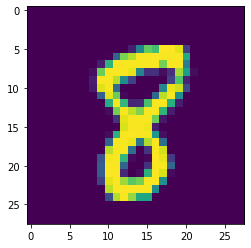

In [3]:
idx = 69420
plt.imshow(X[idx])
y[idx]

In [4]:
def block(f, type='conv', ks=2, s=1, a='relu', bn=True):
    assert type in ['conv', 'deconv']
    layer = tf.keras.layers.Conv2D if type == 'conv' else \
            tf.keras.layers.Conv2DTranspose
    c = layer(f, (ks, ks), strides=(s, s), activation=a)
    bnorm = tf.keras.layers.BatchNormalization()
    return lambda x: bnorm(c(x)) if bn else c(x)

In [5]:
def project(units, a='relu'):
    f = tf.keras.layers.Flatten()
    d = tf.keras.layers.Dense(units, activation=a)
    return lambda x: d(f(x))

In [6]:
def reshape(shape):
    d = tf.keras.layers.Dense(np.prod(shape))
    r = tf.keras.layers.Reshape(shape)
    return lambda x: r(d(x))

In [179]:
def encode(latent_size=32):
    i = tf.keras.Input((28, 28))
    x = i
    x = tf.keras.layers.Reshape((28, 28, 1))(x)
    x = block(128, type='conv', ks=2, s=1, a='relu')(x)
    x = block(64 , type='conv', ks=2, s=1, a='relu')(x)
    x = block(32 , type='conv', ks=2, s=2, a='relu')(x)
    x = block(16 , type='conv', ks=2, s=2, a='relu')(x)
    x = block(8  , type='conv', ks=2, s=2, a='relu')(x)
    x = project(latent_size, a='tanh')(x)
    m = tf.keras.Model(i, x, name='encoder')
    return lambda x: m(x)

In [180]:
def decode(latent_size=32):
    i = tf.keras.Input((latent_size,))
    x = i
    x = reshape((6, 6, 1))(x)
    x = block(8  , type='deconv', ks=2, s=2, a='relu')(x)
    x = block(16 , type='deconv', ks=2, s=2, a='relu')(x)
    x = block(32 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(64 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(128, type='deconv', ks=2, s=1, a='relu')(x)
    x = block(64 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(1  , type='deconv', ks=1, s=1, a='sigmoid', bn=False)(x)
    x = tf.keras.layers.Reshape((28, 28))(x)
    m = tf.keras.Model(i, x, name='decoder')
    return lambda x: m(x)

In [60]:
class AE:
    def __init__(self):
        self.e = encode()
        self.d = decode()

        i = tf.keras.Input((28, 28), name='input')
        x = i
        x = self.e(x)
        x = self.d(x)

        self.net = tf.keras.Model(i, x, name='AE')
        self.net.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.01),
            loss='binary_crossentropy',
            metrics=[],
        )

    def __call__(self, x):
        return self.net(x)

In [10]:
ae = AE()
ae.net.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Model)              (None, 32)                47608     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            79133     
Total params: 126,741
Trainable params: 125,621
Non-trainable params: 1,120
_________________________________________________________________


In [11]:
ae.net.fit(
    x=X,
    y=X,
    batch_size=512,
    epochs=5,
    workers=8,
    use_multiprocessing=True,
)

Train on 70000 samples
Epoch 1/10
70000/70000 [==============================] - 15s 213us/sample - loss: 0.2264
Epoch 2/10
70000/70000 [==============================] - 15s 209us/sample - loss: 0.1228
Epoch 3/10
70000/70000 [==============================] - 15s 213us/sample - loss: 0.1116
Epoch 4/10
70000/70000 [==============================] - 13s 187us/sample - loss: 0.1062
Epoch 5/10
70000/70000 [==============================] - 13s 187us/sample - loss: 0.1031
Epoch 6/10
70000/70000 [==============================] - 13s 185us/sample - loss: 0.1008
Epoch 7/10
70000/70000 [==============================] - 13s 182us/sample - loss: 0.0998
Epoch 8/10
70000/70000 [==============================] - 13s 183us/sample - loss: 0.0985
Epoch 9/10
70000/70000 [==============================] - 13s 184us/sample - loss: 0.0969
Epoch 10/10
70000/70000 [==============================] - 13s 185us/sample - loss: 0.0964



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



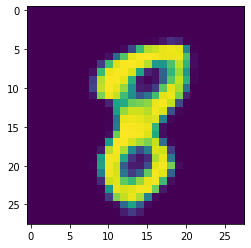

In [12]:
x = X[idx][np.newaxis, ...]
rx = ae(x)[0]
plt.imshow(rx)

In [183]:
def sample(bs, latent_size):
    def sampler(x):
        normal = tf.random.normal((bs, latent_size))
        mean, stddev = tf.split(x, [latent_size, latent_size], axis=1)
        return normal * stddev + mean

    s = tf.keras.layers.Lambda(sampler, name='sampler')
    return lambda x: s(x)

In [238]:
class ProbabilisticAE:
    def __init__(self, bs):
        latent_size = 16
        self.e = encode(latent_size + latent_size)
        self.s = sample(bs, latent_size)
        self.d = decode(latent_size)

        i = tf.keras.Input((28, 28), name='input')
        x = i
        x = self.e(x)
        x = self.s(x)
        x = self.d(x)

        self.net = tf.keras.Model(i, x, name='ProbabilisticAE')
        self.net.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.01),
            loss='binary_crossentropy',
            metrics=[],
        )

    def __call__(self, x):
        return self.net(x)

In [271]:
bs = 500
pae = ProbabilisticAE(bs=bs)
pae.net.summary()

pae.net.fit(
    x=X,
    y=X,
    batch_size=bs,
    epochs=5,
)

Model: "ProbabilisticAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Model)              (None, 32)                47608     
_________________________________________________________________
sampler (Lambda)             (500, 16)                 0         
_________________________________________________________________
decoder (Model)              multiple                  78557     
Total params: 126,165
Trainable params: 125,045
Non-trainable params: 1,120
_________________________________________________________________
Train on 70000 samples
Epoch 1/5
70000/70000 [==============================] - 14s 201us/sample - loss: 0.2755
Epoch 2/5
70000/70000 [==============================] - 13s 185us/sample - loss: 0.1496
Epoch 3/5
70000/70000 [===============

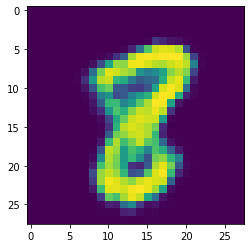

In [275]:
x = X[idx][np.newaxis, ...]
rx = pae(x)[0]
plt.imshow(rx)